# Additional Features

In [59]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
from sklearn.metrics import roc_curve, auc

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [60]:
#Saumya Shah
#Jait Purohit

import sklearn.feature_extraction.text as sk_text
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from pandas import Series
%matplotlib inline
#reading json file into tabular format
import json
import csv
import pandas as pd

In [61]:
filename_read = 'network_intrusion_data.csv'
df = pd.read_csv(filename_read, na_values=['NA','?'])

In [62]:
df.columns = [
'duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'outcome']

In [63]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [68]:
df.shape

(494020, 42)

# 1) Removing Duplicates

In [69]:
X = df[df.columns[:-1]]

In [70]:
print('The number of duplicates is {}\n'.format(X.duplicated().sum()))
print('The total numer of rows is {}'.format(X.shape[0]))

The number of duplicates is 348437

The total numer of rows is 494020


In [71]:
df.loc[df.duplicated(), :]

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
2499,0,tcp,http,SF,307,60990,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,normal.
2863,0,tcp,http,SF,351,11485,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,normal.
2976,0,tcp,http,SF,506,2419,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,normal.
3002,0,tcp,http,SF,319,1374,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,normal.
3129,0,tcp,http,SF,234,1212,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,normal.
3897,0,tcp,http,SF,186,14064,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,normal.
3930,0,tcp,http,SF,309,349,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,normal.
4549,0,tcp,http,SF,312,9384,0,0,0,0,...,255,1.00,0.00,0.06,0.02,0.0,0.0,0.0,0.0,normal.
4550,0,tcp,http,SF,327,4141,0,0,0,0,...,255,1.00,0.00,0.04,0.02,0.0,0.0,0.0,0.0,normal.
4963,0,tcp,http,SF,305,458,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,normal.


In [72]:
print('rows and columns: ' + str(df.shape))
df = df.drop_duplicates()
print('rows and columns after removing duplicates:' + str(df.shape))

rows and columns: (494020, 42)
rows and columns after removing duplicates:(145585, 42)


In [73]:
len(df[df.isnull().any(axis=1)])

0

In [74]:
for i in df.columns:
    print(i," ",len(df[i].unique()))

duration   2495
protocol_type   3
service   66
flag   11
src_bytes   3300
dst_bytes   10725
land   2
wrong_fragment   3
urgent   4
hot   22
num_failed_logins   6
logged_in   2
num_compromised   23
root_shell   2
su_attempted   3
num_root   20
num_file_creations   18
num_shells   3
num_access_files   7
num_outbound_cmds   1
is_host_login   1
is_guest_login   2
count   490
srv_count   470
serror_rate   92
srv_serror_rate   51
rerror_rate   77
srv_rerror_rate   51
same_srv_rate   99
diff_srv_rate   78
srv_diff_host_rate   64
dst_host_count   256
dst_host_srv_count   256
dst_host_same_srv_rate   101
dst_host_diff_srv_rate   101
dst_host_same_src_port_rate   101
dst_host_srv_diff_host_rate   65
dst_host_serror_rate   100
dst_host_srv_serror_rate   72
dst_host_rerror_rate   101
dst_host_srv_rerror_rate   101
outcome   23


# 2) Categorizing outcome attacks

In [75]:
def labels_map(outcome):
    """
     0 - normal
     1 - probing -  surveillance and other probing, e.g., port scanning.
     2 - DOS - denial-of-service, e.g. syn flood;
     3 - U2R - unauthorized access to local superuser (root) privileges, e.g., various __buffer overflow__ attacks;
     4 - R2L - unauthorized access from a remote machine, e.g. guessing password;
    """
    outcome = str(outcome).split('.')[0]
    if outcome == 'normal':
        return 0
    if outcome in ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']: 
        return 1
    if outcome in ['apache2', 'back', 'land', 'mailbomb', 'neptune', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm']:
        return 2
    if outcome in ['buffer_overflow', 'httptunnel', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']: 
        return 3
    if outcome in ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'named', 'phf', 'sendmail', 'snmpgetattack',
                 'snmpguess', 'spy', 'warezclient', 'warezmaster', 'worm', 'xlock', 'xsnoop']: 
        return 4
df['enc_outcome'] = df.outcome.apply(labels_map)

In [124]:
df.enc_outcome.value_counts()

0    87831
2    54572
1     2131
4      999
3       52
Name: enc_outcome, dtype: int64

In [109]:
rows_count = df.shape[0]
df.groupby('enc_outcome').size() * 100/rows_count

enc_outcome
0    60.329704
1     1.463750
2    37.484631
3     0.035718
4     0.686197
dtype: float64

In [76]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,enc_outcome
0,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,0
1,0,tcp,http,SF,235,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,0
2,0,tcp,http,SF,219,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,0
3,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,0


In [77]:
onehotcols = ['protocol_type','service','flag','land','logged_in','root_shell','is_host_login','is_guest_login',]
for i in onehotcols:
    encode_text_dummy(df,i)

In [78]:
df.shape

(145585, 124)

In [79]:
df_new = df

In [82]:
zscorecols = [
'duration',
'src_bytes',
'dst_bytes',
'hot',
'num_compromised',
'num_root',
'num_file_creations',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']
for i in zscorecols:
    print(i," ",len(df[i].unique()))

for i in zscorecols:
    encode_numeric_zscore(df_new,i)

duration   2495
src_bytes   3300
dst_bytes   10725
hot   22
num_compromised   23
num_root   20
num_file_creations   18
count   490
srv_count   470
serror_rate   92
srv_serror_rate   51
rerror_rate   77
srv_rerror_rate   51
same_srv_rate   99
diff_srv_rate   78
srv_diff_host_rate   64
dst_host_count   256
dst_host_srv_count   256
dst_host_same_srv_rate   101
dst_host_diff_srv_rate   101
dst_host_same_src_port_rate   101
dst_host_srv_diff_host_rate   65
dst_host_serror_rate   100
dst_host_srv_serror_rate   72
dst_host_rerror_rate   101
dst_host_srv_rerror_rate   101


In [83]:
df_new.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,su_attempted,num_root,...,flag-SH,land-0,land-1,logged_in-0,logged_in-1,root_shell-0,root_shell-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.10785,-0.004261,-0.039036,0,0,-0.07021,0,-0.007905,0,-0.01039,...,0,1,0,0,1,1,0,1,1,0
1,-0.10785,-0.004263,-0.025041,0,0,-0.07021,0,-0.007905,0,-0.01039,...,0,1,0,0,1,1,0,1,1,0
2,-0.10785,-0.004272,-0.025041,0,0,-0.07021,0,-0.007905,0,-0.01039,...,0,1,0,0,1,1,0,1,1,0
3,-0.10785,-0.004273,-0.013612,0,0,-0.07021,0,-0.007905,0,-0.01039,...,0,1,0,0,1,1,0,1,1,0
4,-0.10785,-0.004273,-0.013612,0,0,-0.07021,0,-0.007905,0,-0.01039,...,0,1,0,0,1,1,0,1,1,0


In [84]:
df_new['enc_outcome'].unique()

array([0, 3, 2, 4, 1])

In [85]:
df_new.shape

(145585, 124)

In [86]:
df_new.drop(columns='outcome',inplace=True)

In [87]:
traincols = df_new.columns.tolist() 

In [88]:
traincols.remove('enc_outcome')

In [89]:
df_new.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,su_attempted,num_root,...,flag-SH,land-0,land-1,logged_in-0,logged_in-1,root_shell-0,root_shell-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.10785,-0.004261,-0.039036,0,0,-0.07021,0,-0.007905,0,-0.01039,...,0,1,0,0,1,1,0,1,1,0
1,-0.10785,-0.004263,-0.025041,0,0,-0.07021,0,-0.007905,0,-0.01039,...,0,1,0,0,1,1,0,1,1,0
2,-0.10785,-0.004272,-0.025041,0,0,-0.07021,0,-0.007905,0,-0.01039,...,0,1,0,0,1,1,0,1,1,0
3,-0.10785,-0.004273,-0.013612,0,0,-0.07021,0,-0.007905,0,-0.01039,...,0,1,0,0,1,1,0,1,1,0
4,-0.10785,-0.004273,-0.013612,0,0,-0.07021,0,-0.007905,0,-0.01039,...,0,1,0,0,1,1,0,1,1,0


In [91]:
x_train, x_test, y_train, y_test = train_test_split(df_new[traincols],df_new['enc_outcome'], test_size=0.2, random_state=42)

In [92]:
#Logistic Regression
from sklearn import metrics
logreg = LogisticRegression()
# fit the model with data
logreg.fit(x_train,y_train)
# predict the response for new observations
logisticprediction = logreg.predict(x_test)

In [93]:
print("Accuracy: ", metrics.accuracy_score(y_test,logisticprediction))
print("Precision: ", metrics.precision_score(y_test,logisticprediction, pos_label=1, average='weighted'))
print("Recall: ", metrics.recall_score(y_test,logisticprediction, pos_label=1, average='weighted'))
print("F1_Score: ", metrics.f1_score(y_test,logisticprediction, pos_label=1, average='weighted'))
print("Confusion Matrix: ", metrics.confusion_matrix(y_test,logisticprediction))

Accuracy:  0.9948827145653741
Precision:  0.9949129899411444
Recall:  0.9948827145653741
F1_Score:  0.9948685815922546
Confusion Matrix:  [[17550     5    13     0    21]
 [   21   397     6     0     1]
 [   61     1 10862     0     0]
 [    1     0     0     4     2]
 [   17     0     0     0   155]]


In [97]:
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

[[17550     5    13     0    21]
 [   21   397     6     0     1]
 [   61     1 10862     0     0]
 [    1     0     0     4     2]
 [   17     0     0     0   155]]
Plotting confusion matrix


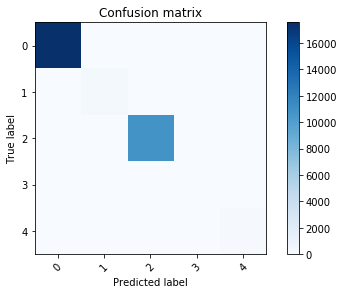

             precision    recall  f1-score   support

          0       0.99      1.00      1.00     17589
          1       0.99      0.93      0.96       425
          2       1.00      0.99      1.00     10924
          3       1.00      0.57      0.73         7
          4       0.87      0.90      0.88       172

avg / total       0.99      0.99      0.99     29117



In [102]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, logisticprediction)
print(cm)
outcome = encode_text_index(df_new,'enc_outcome')

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()
#pred = logisticprediction[:,1]
print(classification_report(y_test, logisticprediction))

# 3) Feature Importance Analysis for Random Forest Classifier

In [111]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth=25, random_state=42)

In [112]:
from sklearn.model_selection import train_test_split
x = df_new[df_new.columns[:-1]]
y = df['enc_outcome']

x_train, x_test, y_train, y_test = train_test_split(df_new[traincols],df_new['enc_outcome'], test_size=0.25, random_state=42)

In [113]:
x_train.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,su_attempted,num_root,...,flag-SH,land-0,land-1,logged_in-0,logged_in-1,root_shell-0,root_shell-1,is_host_login-0,is_guest_login-0,is_guest_login-1
474750,-0.10785,-0.004392,-0.047028,0,0,-0.07021,0,-0.007905,0,-0.01039,...,0,1,0,1,0,1,0,1,1,0
382832,-0.10785,-0.004392,-0.047028,0,0,-0.07021,0,-0.007905,0,-0.01039,...,0,1,0,1,0,1,0,1,1,0
492858,-0.10785,-0.004276,0.140441,0,0,-0.07021,0,-0.007905,0,-0.01039,...,0,1,0,0,1,1,0,1,1,0
22931,-0.10785,-0.004370,-0.045498,0,0,-0.07021,0,-0.007905,0,-0.01039,...,0,1,0,1,0,1,0,1,1,0
13683,-0.10785,-0.004267,-0.039743,0,0,-0.07021,0,-0.007905,0,-0.01039,...,0,1,0,0,1,1,0,1,1,0


In [114]:
y_train.head()

474750    2
382832    2
492858    0
22931     0
13683     0
Name: enc_outcome, dtype: int64

In [115]:
y_test.head()

483593    0
140915    1
106991    0
64590     2
32992     0
Name: enc_outcome, dtype: int64

In [116]:
rf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [117]:
importances=[]
for (x,y) in zip((x_train.axes[1].values),rf.feature_importances_):
    importances.append([x, y])
    
print([i[0] for i in importances])

['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'protocol_type-icmp', 'protocol_type-tcp', 'protocol_type-udp', 'service-IRC', 'service-X11', 'service-Z39_50', 'service-auth', 'service-bgp', 'service-courier', 'service-csnet_ns', 'service-ctf', 'service-daytime', 'service-discard', 'service-domain', 'service-domain_u', 'service-echo', 'service-eco_i', 'service-ecr_i', 'service-efs', 'service-exec', 'service-finger', 'serv

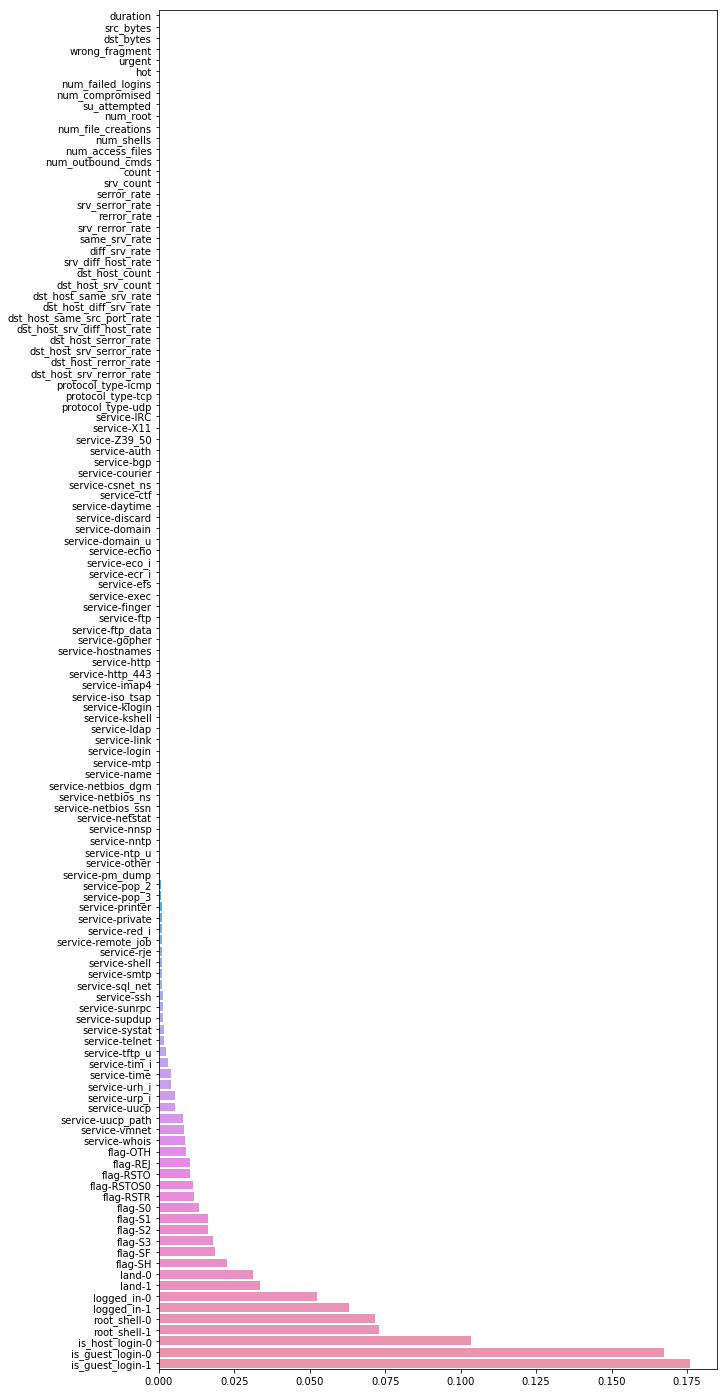

In [118]:
import pandas as pd
import numpy as np

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(10,25))        
sns.barplot(x=np.sort([i[1] for i in importances]),y=[i[0] for i in importances])

# Results of EDA

In [ ]:
We find many feature that doesn't impact on outcome-attacks
Many samples had duplicate, so we have deleted it
It seems that some of features are not important, so we can ignore it

In [138]:
df.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,su_attempted,num_root,...,flag-SH,land-0,land-1,logged_in-0,logged_in-1,root_shell-0,root_shell-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.10785,-0.004261,-0.039036,0,0,-0.07021,0,-0.007905,0,-0.01039,...,0,1,0,0,1,1,0,1,1,0
1,-0.10785,-0.004263,-0.025041,0,0,-0.07021,0,-0.007905,0,-0.01039,...,0,1,0,0,1,1,0,1,1,0
2,-0.10785,-0.004272,-0.025041,0,0,-0.07021,0,-0.007905,0,-0.01039,...,0,1,0,0,1,1,0,1,1,0
3,-0.10785,-0.004273,-0.013612,0,0,-0.07021,0,-0.007905,0,-0.01039,...,0,1,0,0,1,1,0,1,1,0
4,-0.10785,-0.004273,-0.013612,0,0,-0.07021,0,-0.007905,0,-0.01039,...,0,1,0,0,1,1,0,1,1,0


In [142]:
selected_features = ['is_guest_login-1','is_guest_login-0','is_host_login-0','root_shell-1','root_shell-0','logged_in-1','logged_in-0','land-1','land-0']

In [143]:
selected_features

['is_guest_login-1',
 'is_guest_login-0',
 'is_host_login-0',
 'root_shell-1',
 'root_shell-0',
 'logged_in-1',
 'logged_in-0',
 'land-1',
 'land-0']

In [144]:
x_train, x_test, y_train, y_test = train_test_split(df_new[selected_features],df_new['enc_outcome'], test_size=0.25, random_state=42)

In [145]:
RF_Classifier = RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=0)
RF_Classifier.fit(x_train, y_train);

In [146]:
from sklearn import metrics

models = []
models.append(('RandomForest Classifier', RF_Classifier))


============================== {} {} Model Evaluation ==============================

Cross Validation Mean Score:
 0.8458622045207663

Model Accuracy:
 0.8458621826574348

Confusion matrix:
 [[52169     0 13710    14     0]
 [    8     0  1590     0     0]
 [  724     0 40167     0     0]
 [   15     0     5    22     0]
 [  698     0    60     6     0]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.79      0.87     65893
          1       0.00      0.00      0.00      1598
          2       0.72      0.98      0.83     40891
          3       0.52      0.52      0.52        42
          4       0.00      0.00      0.00       764

avg / total       0.86      0.85      0.84    109188


Plotting confusion matrix


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


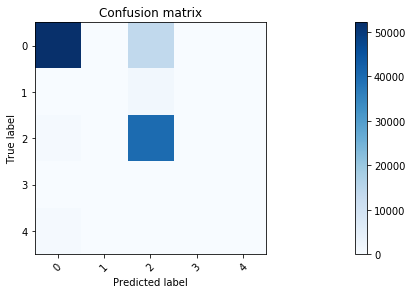

In [153]:
from sklearn.model_selection import cross_val_score

for i, v in models:
    scores = cross_val_score(v, x_train, y_train, cv=10)
    accuracy = metrics.accuracy_score(y_train, v.predict(x_train))
    confusion_matrix = metrics.confusion_matrix(y_train, v.predict(x_train))
    classification = metrics.classification_report(y_train, v.predict(x_train))
    print()
    print('============================== {} {} Model Evaluation ==============================')
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()
    print('Plotting confusion matrix')
    plt.figure()
    plot_confusion_matrix(confusion_matrix, outcome)
    plt.show()